# Vizzuality code challenge

This notebook reads and does a small analysis on the [SPAM](https://www.mapspam.info/data/) dataset

In [1]:
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import seaborn as sns
from rasterio.mask import mask
from rasterio.plot import show

sns.set(style="white")

# Some global configuration
IMAGE_DIRS = [
    "spam2010v2r0_global_phys_area",
    "spam2010v2r0_global_val_prod_agg",
    "spam2010v2r0_global_harv_area",
    "spam2010v2r0_global_prod",
    "spam2010v2r0_global_yield",
]

DATA_BASE_PATH = Path("./data")
CROP_LABEL = "SOYB"  # soy beam

# verbose maps of codes
VARIABLES_MAP = {
    "A": "physical area (ha)",
    "H": "harvested area (ha)",
    "P": "production (t)",
    "Y": "yield (t/ha)",
}

TECHNOLOGY_MAP = {
    "A": "all technologies together",
    "I": "irrigated portion of crop",
    "H": "rainfed high inputs portion of crop",
    "L": "rainfed low inputs portion of crop",
    "S": "rainfed subsistence portion of crop",
    "R": "rainfed portion of crop",
}

## SPAM Data preparation
1. Extract the required images of soy beam
2. Generate the images from the extent defined in `areas.geojson`

In [2]:
soybeam_images = []
for image_dir in IMAGE_DIRS:
    soybeam_images.extend((DATA_BASE_PATH / image_dir).glob(f"*_{CROP_LABEL}_*.tif"))

# should be 24 images for soy beam
# Note that the files for value of production aggregated for all crops is not included.
assert len(soybeam_images) == 24
soybeam_images[:3]

[PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_I.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_S.tif'),
 PosixPath('data/spam2010v2r0_global_phys_area/spam2010V2r0_global_A_SOYB_A.tif')]

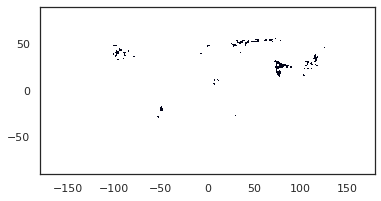

In [3]:
# small check that rasters can be loaded correctly
with rio.open(soybeam_images[1]) as im:
    show(im)
    raster_crs = im.crs

# load the study areas and check that it has the same crs as the rasters
areas = gpd.read_file(DATA_BASE_PATH / "areas.geojson")
areas["region"] = ["india", "america"]

assert str(raster_crs).split(":")[1] == str(areas.crs).split(":")[1]

### Clip with `areas.geojson` and get the regions of interest

In [4]:
dest_dir = DATA_BASE_PATH / "areas"
dest_dir.mkdir(exist_ok=True)

In [5]:
def make_output_filename(image_path: Path, region: str) -> str:
    """Replaces 'global' for region in the filename of image_path
    Expects that filename only has one '.' character
    """
    name, ext = image_path.name.split(".")
    return f"{name.replace('global', region)}.{ext}"


rasters = []
for im in soybeam_images:
    with rio.open(im) as src:
        # apply mask for each area and save new clipped raster
        for area in areas.itertuples():
            out_image, out_transform = mask(src, shapes=[area.geometry], crop=True)
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                }
            )

            with rio.open(
                dest_dir / make_output_filename(im, area.region), "w", **out_meta
            ) as dest:
                dest.write(out_image)
                rasters.append(dest.name)

Now we have the areas of interest extracted and listed in `rasters` but it is still a bit messy to play around with it.
It is time to make some data organization helper with a `dataclass`.

In [6]:
@dataclass
class SpamData:
    filename: Path
    version: str
    region: str
    variable: str
    crop: str
    technology: str

    @classmethod
    def from_file(cls, filename: str):
        filename = Path(filename)
        attrs = filename.name.split(".")[0].split("_")
        return cls(filename, *attrs)

    def get_description(self) -> str:
        return f"{VARIABLES_MAP[self.variable]}, {TECHNOLOGY_MAP[self.technology]}"

In [7]:
rasters = [SpamData.from_file(f) for f in rasters]

Now we can filter things out easily

In [8]:
[r for r in rasters if r.region == "india"][:3]

[SpamData(filename=PosixPath('data/areas/spam2010V2r0_india_A_SOYB_I.tif'), version='spam2010V2r0', region='india', variable='A', crop='SOYB', technology='I'),
 SpamData(filename=PosixPath('data/areas/spam2010V2r0_india_A_SOYB_S.tif'), version='spam2010V2r0', region='india', variable='A', crop='SOYB', technology='S'),
 SpamData(filename=PosixPath('data/areas/spam2010V2r0_india_A_SOYB_A.tif'), version='spam2010V2r0', region='india', variable='A', crop='SOYB', technology='A')]

## Visualize SPAM data

This section makes plotting helpers to explore the SPAM dataset.

In [9]:
def plot_map_on_ax(ax, raster_filename, areas, proj, mask_thresh=0, **imshow_kwargs):
    """Plots raster on Cartopy GeoAxes and adds map features"""
    with rio.open(raster_filename, "r") as src:
        im = src.read(1)
        extent = rio.plot.plotting_extent(src)

    # get the extent for the base map and add some room to have context
    x0, x1, y0, y1 = extent
    x0, x1, y0, y1 = x0 - 2, x1 + 2, y0 - 2, y1 + 2
    ax.set_extent([x0, x1, y0, y1], crs=proj)

    # add data extend boundary from areas.geojson
    areas_ax = areas.to_crs(proj.proj4_init).boundary.plot(
        ax=ax, linestyle=(0, (1, 5)), color="k", label="Data extent"
    )

    im = np.ma.masked_where(im <= mask_thresh, im)

    # rasterio.plot.show() doesn't work well when using cartopy
    # so using the cartopy patched imshow() instead
    im_ax = ax.imshow(im, transform=proj, extent=extent, **imshow_kwargs)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.OCEAN)
    return im_ax, areas_ax


def plot_spam_data(raster: SpamData, **imshow_kwargs):
    fig = plt.figure(figsize=(10, 5))
    proj = ccrs.PlateCarree()  # sets the cartopy map projection
    ax = fig.add_subplot(111, projection=proj)

    im_ax, _ = plot_map_on_ax(ax, raster.filename, areas, proj, **imshow_kwargs)
    ax.legend()
    fig.colorbar(im_ax, ax=ax)
    ax.set_title(f"Soy Beam\n{raster.get_description()}")
    plt.tight_layout()

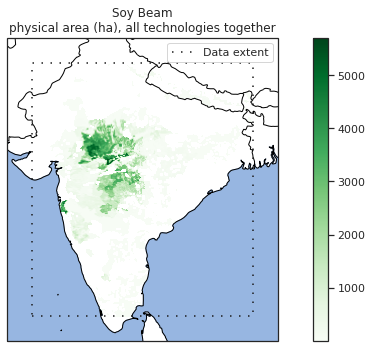

In [10]:
plot_spam_data(rasters[4], cmap="Greens")

In [11]:
def get_SPAM_rasters_by_codes(
    rasters: list[SpamData], var: str, tech: str
) -> list[SpamData]:
    """Filter raster list by variable, technology."""
    return [r for r in rasters if r.variable in var and r.technology in tech]


def compare_rasters(rasters: list[SpamData]):
    """Plot two rasters side by side"""
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=[14, 8])
    ax1 = fig.add_subplot(121, projection=proj)
    ax2 = fig.add_subplot(122, projection=proj)

    # get max and min value for both rasters so they can use the same intensity color scale
    # This solution is quite suboptimal since it reads the rasters before plotting :^/
    vmin, vmax = np.inf, 0
    for raster in rasters:
        with rio.open(raster.filename, "r") as src:
            im = src.read(1)
        vmin = np.min(im, initial=vmin)
        vmax = np.max(im, initial=vmax)

    for raster, ax in zip(rasters, [ax1, ax2]):
        im_ax, _ = plot_map_on_ax(
            ax, raster.filename, areas, proj, vmin=vmin, vmax=vmax, cmap="Greens"
        )
        ax.set_title("{}\n{}".format(*raster.get_description().split(", ")))
    # set the colorbar for the last processed raster
    fig.colorbar(im_ax, ax=[ax1, ax2])
    ax1.legend()
    ax2.legend()

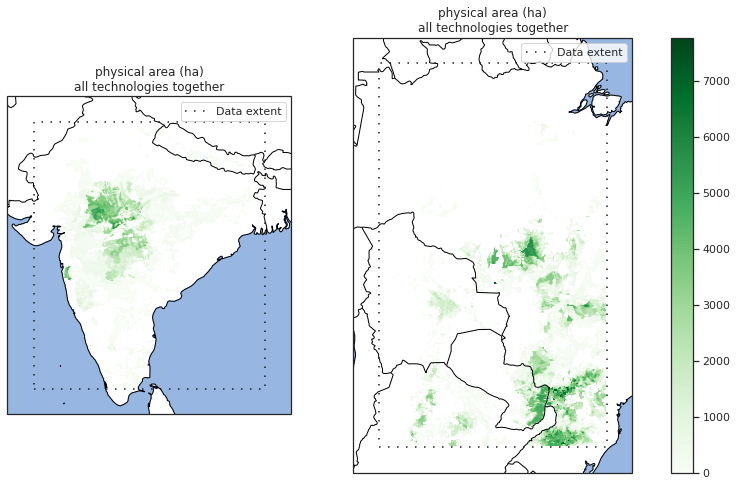

In [12]:
area_all_tech = get_SPAM_rasters_by_codes(rasters, var="A", tech="A")
compare_rasters(area_all_tech)

In [13]:
# get the raster sizes
region_size = {}
for r in area_all_tech:
    with rio.open(r.filename) as src:
        region_size[r.region] = src.read(1).size

In [14]:
region_size

{'india': 55913, 'america': 85050}

In [15]:
def make_dataframe_from_rasters(rasters: list[SpamData]):
    data = defaultdict(list)
    region_order = []
    for raster in rasters:
        with rio.open(raster.filename) as src:
            values = src.read(1)
            data[TECHNOLOGY_MAP[raster.technology]].extend(src.read(1).ravel())
            region_order.append(raster.region)
    
    # No Data in SPAM rasters is -1
    df = pd.DataFrame(data).replace(-1, np.nan)
    
    # make the region column using the correct order of inserion
    region_labels = [region_order[0]] * region_size[region_order[0]]
    region_labels.extend([region_order[1]] * region_size[region_order[1]])
    
    df["region"] = pd.Categorical(region_labels, categories=region_size.keys())
    return df

In [16]:
# from matplotlib.ticker import


def plot_variable(rasters, var: str, reduction: str = "sum"):
    """Plots bars grouped by region for the given variable."""
    # get all the rasters with the variable var
    rasters = [r for r in rasters if r.variable == var]
    df = make_dataframe_from_rasters(rasters)

    # aggregate the dataframe by region and apply the provided reduction name
    # the resulting reduced df has the regions as index, one column for each tech
    # and the value is the result of the reduction
    reduced = getattr(df.groupby("region"), reduction)()

    fig, ax = plt.subplots(figsize=(10, 7))
    reduced.plot(kind="bar", ax=ax)  # pandas default plots are so ugly :(
    ax.set_ylabel(VARIABLES_MAP[var])

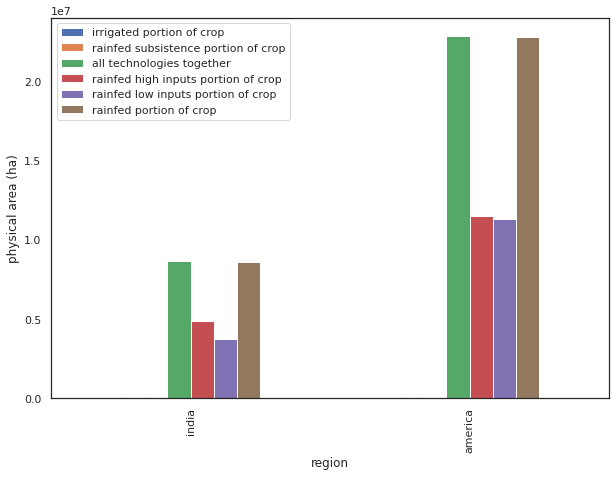

In [17]:
plot_variable(rasters, "A")

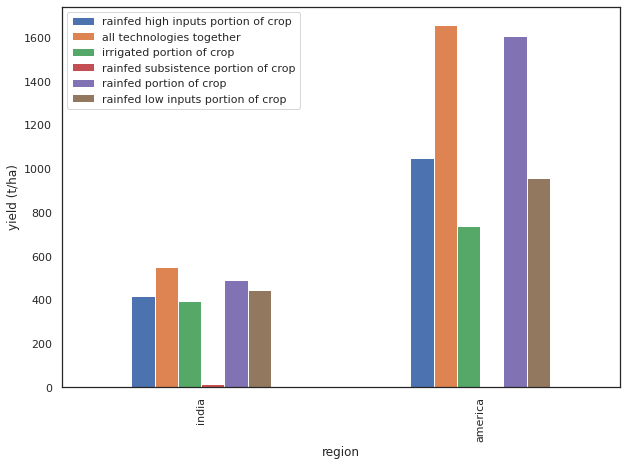

In [18]:
plot_variable(rasters, "Y", "mean")

## Global Forest Change data preparation
We are going to merge and clip the rasters

In [19]:
forest_data_path = DATA_BASE_PATH / "forest"

The issue with the Global Forest Change data is that even only using a subset of it for our regions of interest
it is still a huge amount of data. Rasterio can't merge the rasters without MemoryError, so we are going to use `gdal_merge` which is more
optimized and has more knobs to tweak.

In [ ]:
# Note! it takes around ~5 minutes in my workstation
from osgeo_utils import gdal_merge

# merge rasters and clip by the bounds of areas.geojson
# generating two rasters, one for each region
for area in areas.itertuples():
    print(f"merging {area.region} rasters...")
    forest_loss_rasters = [
        str(r) for r in (forest_data_path / area.region).glob("*tif")
    ]
    output_file_path = str(forest_data_path / area.region / "merged.tif")

    # gdal takes the bound params in the order: minx, maxy, maxx, miny
    # while geometry.bounds returns [minx, miny, maxx, maxy]
    bounds = [str(v) for v in area.geometry.bounds]
    bounds_param = ["-ul_lr", bounds[0], bounds[3], bounds[2], bounds[1]]

    options = ["-of", "GTiff", "-co", "tiled=yes", "-co", "COMPRESS=LZW"]
    parameters = (
        ["", "-o", output_file_path] + forest_loss_rasters + options + bounds_param
    )
    gdal_merge.main(parameters)
    print(" ")  # extra print to flush the stdout?

merging india rasters...
0...10...20...30...40...50...60...70...80... 
merging america rasters...
90...100 - done.
0...10...20...30...40...50...60...70..

Now we have a nice single raster for each region. The Issue here is that it is still high resolution and super compressed so when we try to draw it with matplotlib the memory goes brrr.

We could now try a few things to work with it as an array like using an sparse matrix (since most of the cells are 0) or down sampling to make the array smaller. I will go with **down sampling** to match the resolution of our SPAM rasters, so they are easier to compare. The resampling method I decided to go with is `Resampling.max`.
This changes the meaning of the cells to **last forest loss event in the last 20 years**. 

In [ ]:
from rasterio.warp import Resampling, calculate_default_transform, reproject


# function extracted from https://pygis.io/docs/e_raster_resample.html
def coregister(infile: str, match: str, outfile: str) -> None:
    """Reproject a file to match the shape and projection of existing raster.

    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection
    outfile : (string) path to output file tif
    """
    with rio.open(infile) as src:
        src_transform = src.transform

        with rio.open(match) as match:
            dst_crs = match.crs
            # get the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,
                dst_crs,
                match.width,
                match.height,
                *match.bounds,
            )

        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                "crs": dst_crs,
                "transform": dst_transform,
                "width": dst_width,
                "height": dst_height,
                "nodata": 0,
            }
        )

        with rio.open(outfile, "w", **dst_kwargs) as dst:
            reproject(
                source=rio.band(src, 1),
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.max,
            )

In [ ]:
coregister(
    forest_data_path / "india" / "merged.tif",
    rasters[4].filename,
    forest_data_path / "india" / "correg.tif",
)
coregister(
    forest_data_path / "america" / "merged.tif",
    rasters[3].filename,
    forest_data_path / "america" / "correg.tif",
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()  # sets the cartopy map projection
ax = fig.add_subplot(111, projection=proj)

im_ax, _ = plot_map_on_ax(
    ax,
    forest_data_path / "america" / "correg.tif",
    areas,
    proj,
    cmap="Reds",
    interpolation="none",
)

fig.colorbar(im_ax, ax=ax)
ax.set_title(f"Forest loss for period 2000-2020")
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(10, 6))
proj = ccrs.PlateCarree()  # sets the cartopy map projection
ax = fig.add_subplot(111, projection=proj)

im_ax, _ = plot_map_on_ax(
    ax,
    forest_data_path / "india" / "correg.tif",
    areas,
    proj,
    cmap="Reds",
    interpolation="none",
)

fig.colorbar(im_ax, ax=ax)
ax.set_title(f"Forest loss for period 2000-2020")
plt.tight_layout()

We can see that forest loss is quite more present in the South America region.

##  How is the forest loss affected by the area of soy beam crops

This section is the actual analysis. 
Now that we have the tools to easily filter and show the data it will be clean and straight forward to get some insights.

According to the SPAM dataset metadata the time period covered ends at 2011-12-31. On the other hand the forest loss is up to 2020. We destroyed a lot of information when down sampling. This leads us to having to make some hard assumptions like that an emerging soy beam crop recorded in the SPAM dataset can have an impact on the forest loss even years after the record date.

In [ ]:
import matplotlib.patches as mpatches
from matplotlib import colors


def plot_loss_on_spam(loss_raster: str, spam_raster: SpamData):
    """Helper to plot forest loss rasters on top of soy beam data."""
    fig = plt.figure(figsize=(12, 9))
    proj = ccrs.PlateCarree()  # sets the cartopy map projection
    ax = fig.add_subplot(111, projection=proj)

    im_ax, box_ax = plot_map_on_ax(
        ax,
        spam_raster.filename,
        areas,
        proj,
        cmap="viridis",
        interpolation="none",
    )
    cbar = fig.colorbar(im_ax, ax=ax)
    cbar.set_label(VARIABLES_MAP[spam_raster.variable])

    with rio.open(loss_raster) as src:
        # Define a reclassified forest loss raster with 1 for loss event and 0 no loss
        reclass_forest_loss = np.where(src.read(1) > 0, 1, 0)
        extent = rio.plot.plotting_extent(src)

    forest_cmap = colors.ListedColormap(["red"])
    ax.imshow(
        np.ma.masked_where(reclass_forest_loss <= 0, reclass_forest_loss),
        transform=proj,
        extent=extent,
        interpolation="none",
        cmap=forest_cmap,
    )

    # add the forest loss to the legend
    patches = [mpatches.Patch(color=forest_cmap.colors[0], label="Forest loss")]

    ax.legend(handles=patches)
    ax.set_title(
        f"Forest loss for period 2000-2020 & \n Soy beam crops 2010 ({TECHNOLOGY_MAP[spam_raster.technology]})"
    )

In [ ]:
america_forest_loss = forest_data_path / "america" / "correg.tif"
america_spam_area = [
    r
    for r in get_SPAM_rasters_by_codes(rasters, var="A", tech="A")
    if r.region == "america"
][0]

plot_loss_on_spam(america_forest_loss, america_spam_area)

From the image above we can see that there is some correlation between pixels of low physical areas of Soy Beam and events of forest loss.

Now let's take a closer look to the data

In [ ]:
with rio.open(america_spam_area.filename) as src:
    soyb_area_raster = src.read(1)

with rio.open(america_forest_loss) as src:
    # Define a reclassified forest loss raster with 1 for loss event and 0 no loss
    reclass_forest_loss = np.where(src.read(1) > 0, 1, 0)

# mask for where pixels with meaningful values of forest loss
# and soy beam crops coincide.
mask = np.logical_and(soyb_area_raster > 0, reclass_forest_loss > 0)

In [ ]:
print(
    f"{(mask.sum() / (reclass_forest_loss > 0).sum()) * 100:.3}% of forest loss events "
    "are in pixels with soy beam crops"
)

looks quite high! Lets looks at the distribution of physical area that have forest loss events

In [ ]:
ax = sns.histplot(soyb_area_raster[mask].ravel(), bins=30, stat="percent")
ax.set_title("Distribution of physical areas where there is an event of forest loss.")
ax.set_xlabel(VARIABLES_MAP[america_spam_area.variable]);

In the chart above we can see that the forest loss events have a high frequency in the zones with low area of soy beam crops. This could be explained by the fact that in the zones with high area of soy beam crops there is already a no forest.
On the other hand, this result could be interpreted that the zones with low physical area of soy beam are currently under a heavy agricultural development, which lead to the loss of forests.